# (h) Langevin dynamics
### Data reconstruction

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
from torch import Tensor
import torch.nn as nn
import torch.cuda as cuda
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, Dataset
from torch.nn.parameter import Parameter

try:
    import accimage
except ImportError:
    accimage = None

import random
import copy
import time

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import ImageFolder

from SpykeTorch import snn
from SpykeTorch import functional as sf
from SpykeTorch import visualization as vis
from SpykeTorch import utils

import struct
import glob
import datetime
import re

from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix
import scipy.stats as sps
from scipy.stats.mstats import mquantiles

import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from PIL import Image

#import import_ipynb
#from MozafariMNIST2018_class import MozafariMNIST2018

In [2]:
use_cuda = True

if torch.cuda.is_available():
    print("CUDA is available")
    device = torch.device("cuda")

CUDA is available


## Initial data

In [3]:
# location of storage of weight's sets
# obtained as a result of working with the "(h)_Langevin_dynamics_(initial_train_on_digits).ipynb" file
path = f'./sets_of_weights_for_Langevin_dynamics/'

# tensor size check
torch.load(f'{path}set_of_weights_0.pt').size()

torch.Size([240, 1250000])

## Reconstruction sets of weights after training on digits
Data from 24 files with 240 sets of weights per file were decomposed and reconstructed:     
a history of weight changes was compiled and quantiles were extracted

In [4]:
experiment_number = 0
number_of_files = 25

In [5]:
ss_0 = time.time()

print('Data reconstruction:')

# location of storage of sets of weights 
# obtained as a result of working with the "(h)_Langevin_dynamics_(initial_train_on_digits).ipynb" file
path = f'./sets_of_weights_for_Langevin_dynamics/'

for k in range(200):
    
    seconds_0 = time.time()
    
    globals()[f'primary_set_of_weights_{k}'] = torch.load(f'{path}set_of_weights_0.pt', \
                                                map_location=torch.device('cuda'))[:, 6250*k:6250*(k+1)]
    
    for i in range(1, number_of_files-1): 
        temporary = torch.load(f'{path}set_of_weights_{i}.pt', \
                               map_location=torch.device('cuda'))[:, 6250*k:6250*(k+1)]
        globals()[f'primary_set_of_weights_{k}'] = torch.cat((globals()[f'primary_set_of_weights_{k}'], \
                                                                  temporary), 0)
    torch.save(globals()[f'primary_set_of_weights_{k}'], f'{path}primary_set_of_weights_{experiment_number}_{k}.pt')
    del globals()[f'primary_set_of_weights_{k}']
    torch.cuda.empty_cache()
    
    seconds_1 = time.time()  
    print(f'- oper.time of range# {k}: '
          f'{int((seconds_1 - seconds_0)//60)} min {int((seconds_1 - seconds_0)%60)} sec')     
    
ss_1 = time.time()  
print('--'*20)
print(f'Total operational time: '
      f'{int((ss_1 - ss_0)//60)} min {int((ss_1 - ss_0)%60)} sec') 

Data reconstruction:
- oper.time of range# 0: 0 min 14 sec
- oper.time of range# 1: 0 min 15 sec
- oper.time of range# 2: 0 min 14 sec
- oper.time of range# 3: 0 min 14 sec
- oper.time of range# 4: 0 min 15 sec
- oper.time of range# 5: 0 min 13 sec
- oper.time of range# 6: 0 min 11 sec
- oper.time of range# 7: 0 min 11 sec
- oper.time of range# 8: 0 min 11 sec
- oper.time of range# 9: 0 min 11 sec
- oper.time of range# 10: 0 min 12 sec
- oper.time of range# 11: 0 min 11 sec
- oper.time of range# 12: 0 min 11 sec
- oper.time of range# 13: 0 min 11 sec
- oper.time of range# 14: 0 min 11 sec
- oper.time of range# 15: 0 min 11 sec
- oper.time of range# 16: 0 min 11 sec
- oper.time of range# 17: 0 min 11 sec
- oper.time of range# 18: 0 min 11 sec
- oper.time of range# 19: 0 min 14 sec
- oper.time of range# 20: 0 min 11 sec
- oper.time of range# 21: 0 min 17 sec
- oper.time of range# 22: 0 min 11 sec
- oper.time of range# 23: 0 min 11 sec
- oper.time of range# 24: 0 min 11 sec
- oper.time of

## Calculations of deciles D10 (10%), D50 (50%) and D90 (90%)

In [6]:
# location of storage of sets of weights 
# obtained as a result of working with the "(h)_Langevin_dynamics_(initial_train_on_digits).ipynb" file
path = f'./sets_of_weights_for_Langevin_dynamics/'

primary_set_of_weights = torch.load(f'{path}primary_set_of_weights_{experiment_number}_0.pt', \
                                            map_location=torch.device('cpu'))
quantiles = mquantiles(primary_set_of_weights, prob=[0.1, 0.5, 0.9], axis=0)   
quantiles = torch.tensor(quantiles)

print("Calculation of quantiles:")

seconds_0 = time.time() 

for i in range(1, 200):   
    ss_0 = time.time()
    
    current_set_of_weights = torch.load(f'{path}primary_set_of_weights_{experiment_number}_{i}.pt', \
                                                map_location=torch.device('cpu'))
    current_quantiles = mquantiles(current_set_of_weights, prob=[0.1, 0.5, 0.9], axis=0)
    current_quantiles = torch.tensor(current_quantiles)
    quantiles = torch.cat((quantiles, current_quantiles), 1)

    ss_1 = time.time()  
    print(f'- oper.time# {i}: {int((ss_1 - ss_0)%60)} sec') 

seconds_1 = time.time()
print(f'Total operational time: '
          f'{int((seconds_1 - seconds_0)//60)} min {int((seconds_1 - seconds_0)%60)} sec')

Calculation of quantiles:
- oper.time# 1: 1 sec
- oper.time# 2: 1 sec
- oper.time# 3: 1 sec
- oper.time# 4: 1 sec
- oper.time# 5: 1 sec
- oper.time# 6: 1 sec
- oper.time# 7: 1 sec
- oper.time# 8: 1 sec
- oper.time# 9: 1 sec
- oper.time# 10: 1 sec
- oper.time# 11: 1 sec
- oper.time# 12: 1 sec
- oper.time# 13: 1 sec
- oper.time# 14: 1 sec
- oper.time# 15: 1 sec
- oper.time# 16: 1 sec
- oper.time# 17: 1 sec
- oper.time# 18: 1 sec
- oper.time# 19: 1 sec
- oper.time# 20: 1 sec
- oper.time# 21: 1 sec
- oper.time# 22: 1 sec
- oper.time# 23: 1 sec
- oper.time# 24: 1 sec
- oper.time# 25: 1 sec
- oper.time# 26: 1 sec
- oper.time# 27: 1 sec
- oper.time# 28: 1 sec
- oper.time# 29: 1 sec
- oper.time# 30: 1 sec
- oper.time# 31: 1 sec
- oper.time# 32: 1 sec
- oper.time# 33: 1 sec
- oper.time# 34: 1 sec
- oper.time# 35: 1 sec
- oper.time# 36: 1 sec
- oper.time# 37: 1 sec
- oper.time# 38: 1 sec
- oper.time# 39: 1 sec
- oper.time# 40: 1 sec
- oper.time# 41: 1 sec
- oper.time# 42: 1 sec
- oper.time# 43: 

In [7]:
quantiles.size()

torch.Size([3, 1250000])

## Decile D10 (10%)

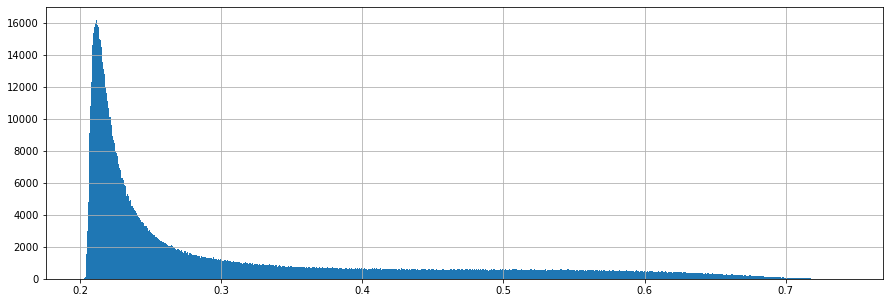

In [9]:
plt.subplots(figsize=(15, 5))
plt.hist(np.array(quantiles[0]), bins=1000);
plt.grid()

## Decile D50 (50%)

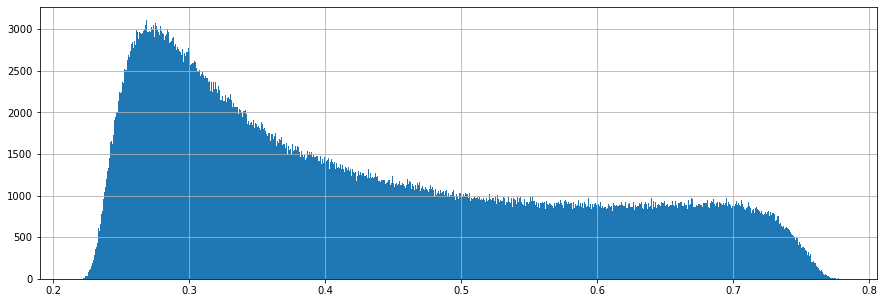

In [10]:
plt.subplots(figsize=(15, 5))
plt.hist(np.array(quantiles[1]), bins=1000);
plt.grid()

## Decile D90 (90%)

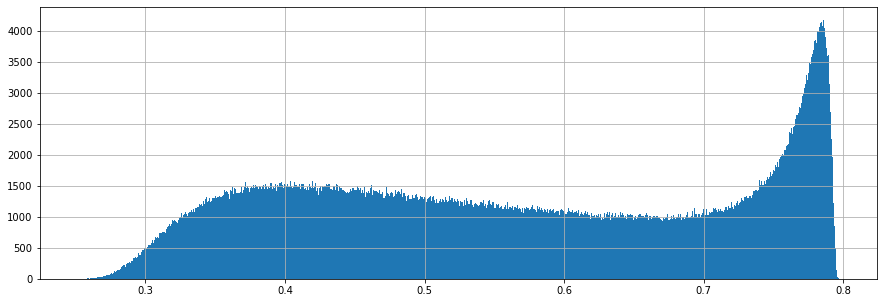

In [11]:
plt.subplots(figsize=(15, 5))
plt.hist(np.array(quantiles[2]), bins=1000);
plt.grid()

## D90 - D10

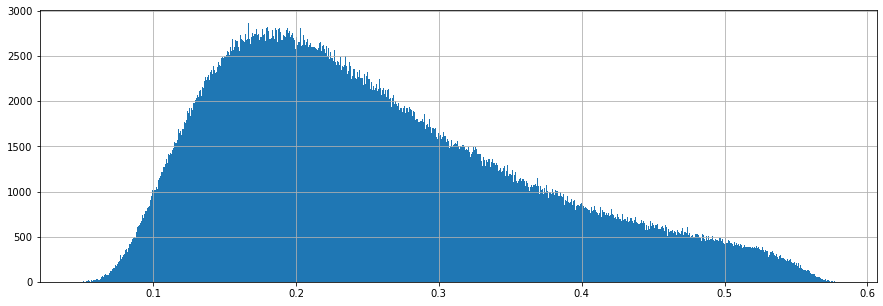

In [12]:
plt.subplots(figsize=(15, 5))
plt.hist(np.array(quantiles[2] - quantiles[0]), bins=1000);
plt.grid()

In [13]:
torch.save(quantiles, f'{path}quantiles_{experiment_number}.pt')